<a href="https://colab.research.google.com/github/skoppalu/Regression-Projects/blob/main/RegressionProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer,OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor


In [ ]:
def load_housing_data():
  tarball_path=Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url='https://github.com/ageron/data/raw/main/housing.tgz'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets')
  return pd.read_csv(Path('datasets/housing/housing.csv'))

housing_full=load_housing_data()

/tmp/ipython-input-64111482.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path='datasets')


In [ ]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing_full['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

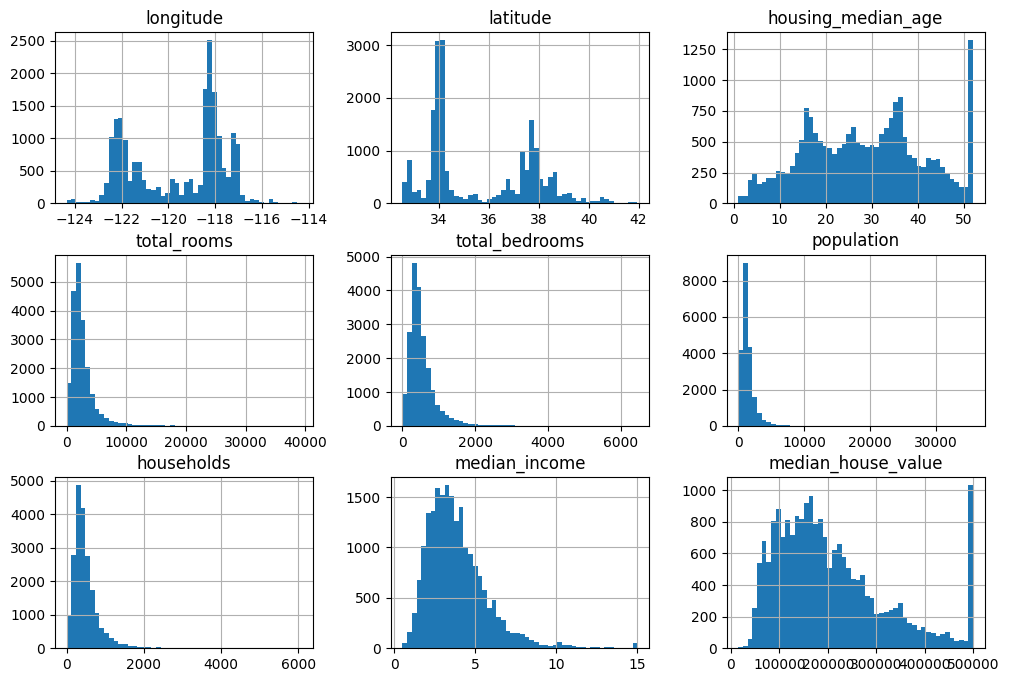

In [ ]:
housing_full.hist(bins=50, figsize=(12,8))

In [ ]:
def shuffle_and_split_data(data, test_ratio, rng):
  shuffled_indices=rng.permutation(len(data))
  test_set_size=int(len(data)*test_ratio)
  test_indices=shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
rng=np.random.default_rng(seed=42)
train_set, test_set=shuffle_and_split_data(housing_full, 0.2, rng)
len(train_set)
len(test_set)

4128

In [ ]:
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier))<test_ratio*2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids=data[id_column]
  in_test_set=ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]




In [ ]:
housing_with_id=housing_full.reset_index()
train_set, test_set=split_data_with_id_hash(housing_with_id, 0.2, 'index')

In [ ]:
housing_with_id['id']=housing_full['longitude']*100+housing_full['latitude']
train_set, test_set=split_data_with_id_hash(housing_with_id, 0.2, 'id')

In [ ]:
train_set, test_set= train_test_split(housing_full, test_size=0.2, random_state=42)

In [ ]:
housing_full['income_cat']=pd.cut(housing_full['median_income'],
                                  bins=[0.,1.5,3.0,4.5,6,np.inf],
                                  labels=[1,2,3,4,5])


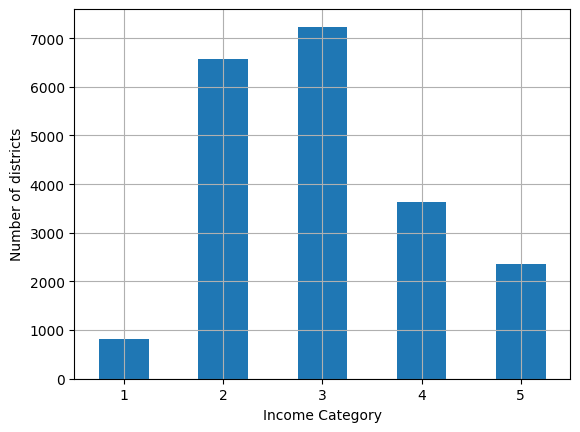

In [ ]:
cat_counts=housing_full['income_cat'].value_counts().sort_index()
cat_counts.plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
splitter=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits=[]
for train_index, test_index in splitter.split(housing_full, housing_full['income_cat']):

  strat_train_set_n=housing_full.iloc[train_index]
  start_test_set_n=housing_full.iloc[test_index]
  strat_splits.append([strat_train_set_n, start_test_set_n])

In [ ]:
start_train_set, start_test_set_n=strat_splits[0]

In [ ]:
start_train_set, start_test_set= train_test_split(housing_full, test_size=0.2, stratify=housing_full['income_cat'], random_state=42)

In [ ]:
start_test_set['income_cat'].value_counts()/len(start_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [ ]:
for set_ in (start_train_set, start_test_set):
  # set_.drop('income_cat', axis=1, inplace=True)
  set_.drop(columns=['income_cat'],inplace=True)

### **Explore and Visualize the Data to Gain Insights**

In [ ]:
housing=start_train_set.copy()

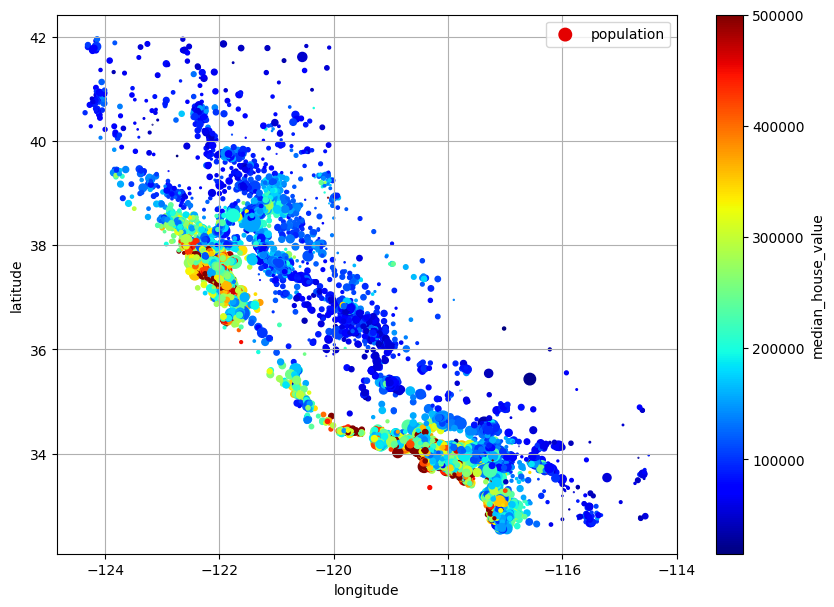

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude',grid=True,
             s=housing['population']/100, label='population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

In [ ]:
corr_matrix=housing.corr(numeric_only=True)

In [ ]:
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


In [ ]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


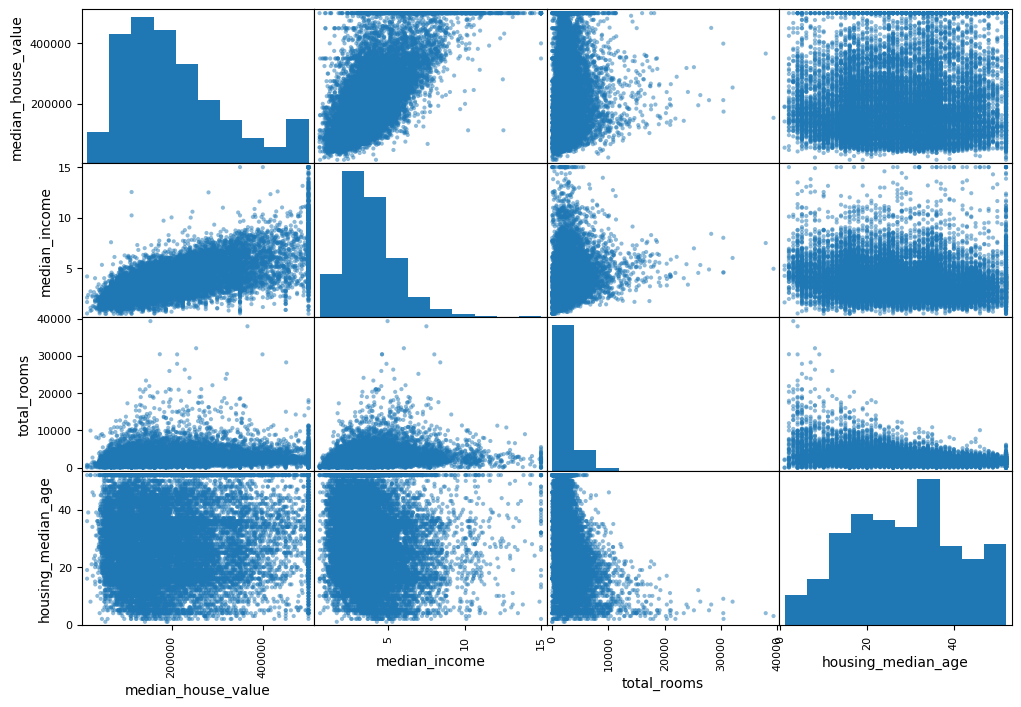

In [ ]:
attributes=['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

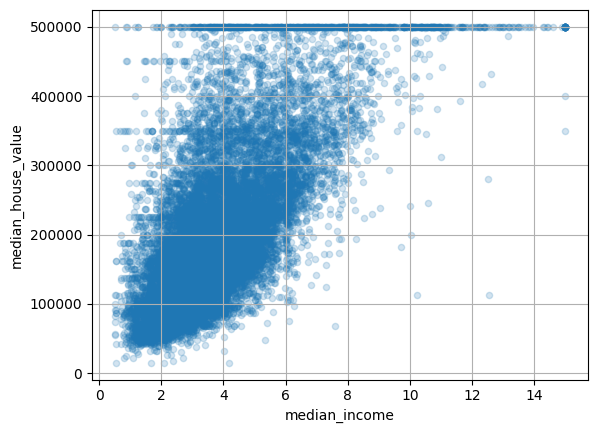

In [ ]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.2, grid=True)

In [ ]:
housing['rooms_per_house']=housing['total_rooms']/housing['households']
housing['bedrooms_ratio']=housing['total_bedrooms']/housing['total_rooms']
housing['people_per_house']=housing['population']/housing['households']

In [ ]:
corr_matrix=housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


Prepare Data for ML

In [ ]:
housing=start_train_set.drop('median_house_value', axis=1)
housing_labels=start_train_set['median_house_value'].copy()

Clean the data

In [ ]:
# housing.dropna(subset=['total_bedrooms'], inplace=True)
# housing.drop("total_bedrooms", axis=1, inplace=True)
median=housing['total_bedrooms'].median()
housing['total_bedrooms']=housing['total_bedrooms'].fillna(median)

In [ ]:
imputer=SimpleImputer(strategy='median')

In [ ]:
housing_num=housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
X=imputer.transform(housing_num)

In [ ]:
housing_tr= pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

Handling Text and Categorical Attributes

In [ ]:
housing_cat=housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [ ]:
ordinal_encoder=OrdinalEncoder()
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_encoded

array([[3.],
       [0.],
       [1.],
       ...,
       [4.],
       [0.],
       [4.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
df_test=pd.DataFrame({'ocean_proximity':['INLAND', 'NEAR BAY']})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [ ]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [ ]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
# to tranform any df into the format the encoder was actually traiend on
# df_output=pd.DataFrame(cat_encoder.transform(df_test_unkown),
#                        columns=cat_encoder.get_feature_names_out(),
#                        index=df_test_unkown.index)

In [ ]:
min_max_scaler=MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled=min_max_scaler.fit_transform(housing_num)

In [ ]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

In [ ]:
std_scaler=StandardScaler()
housing_num_std_scaled=std_scaler.fit_transform(housing_num)

In [ ]:
housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

In [ ]:
age_simil_35=rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [ ]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [ ]:
target_scaler=StandardScaler()
scaled_labels=target_scaler.fit_transform(housing_labels.to_frame())


model=LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data=housing[['median_income']].iloc[:5]

scaled_predictions=model.predict(some_new_data)
predictions=target_scaler.inverse_transform(scaled_predictions)

In [ ]:
scaled_predictions

array([[-0.64466228],
       [ 0.80674175],
       [-0.52302364],
       [-0.5853166 ],
       [-0.12415952]])

In [ ]:
model=TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions=model.predict(some_new_data)

In [ ]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [ ]:
log_transformer=FunctionTransformer(np.log, inverse_func=np.exp)
log_pop=log_transformer.transform(housing[['population']])

In [ ]:
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [ ]:
rbf_transformer=FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35=rbf_transformer.transform(housing[['housing_median_age']])

In [ ]:
sf_coords=37.7749, -122.41
sf_transformer=FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil=sf_transformer.transform(housing[['latitude', 'longitude']])

In [66]:
!git clone https://github.com/skoppalu/Regression-Projects.git
%cd Regression-Projects


Cloning into 'Regression-Projects'...
/content/Regression-Projects


In [72]:
# Go to your local repo folder in Colab
%cd /content/Regression-Projects

# Copy the notebook from its subfolder into the repo folder
!cp "/Colab Notebooks/ML_Study_Sessions/RegressionProject1.ipynb" .

# Stage, commit, and push
!git add RegressionProject1.ipynb
!git commit -m "Update RegressionProject1 notebook"
!git push origin main


/content/Regression-Projects
cp: cannot stat '/Colab Notebooks/ML_Study_Sessions/RegressionProject1.ipynb': No such file or directory
fatal: pathspec 'RegressionProject1.ipynb' did not match any files
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@2f0a80933297.(none)')
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/skoppalu/Regression-Projects.git'
